# Score-matching informed KDE

In [1]:
import matplotlib.pyplot as plt
import os
import torch
import torch.optim as optim
import torch.nn as nn
from torch.distributions.multivariate_normal import MultivariateNormal
import lib.toy_data as toy_data
import numpy as np
import argparse
import pandas as pd
from pandas.plotting import scatter_matrix as pdsm

### Parsing for scripts

In [2]:
parser = argparse.ArgumentParser('simple_sgm_experiments')
parser.add_argument('--data', choices=['swissroll', '8gaussians', 'pinwheel', 'circles', 'moons', '2spirals', 'checkerboard', 'rings'], type = str,default = 'moons')
parser.add_argument('--depth',help = 'number of hidden layers of score network',type =int, default = 7)
parser.add_argument('--hiddenunits',help = 'number of nodes per hidden layer', type = int, default = 32)
parser.add_argument('--niters',type = int, default = 100000)
parser.add_argument('--batch_size', type = int,default = 64)
parser.add_argument('--lr',type = float, default = 1e-3) 
parser.add_argument('--finalT',type = float, default = 5)
parser.add_argument('--dt',type = float,help = 'integrator step size', default = 0.001)
parser.add_argument('--save',type = str,default = 'experiments/simple_sgm/')

args = parser.parse_args('')

### Precision matrix model

In [3]:
## Cholesky factor model

def construct_factor_model(dim:int, depth:int, hidden_units:int):
    '''
    Initializes neural network that models the Cholesky factor of the precision matrix # For nD examples (in theory)
    '''
    chain = []
    chain.append(nn.Linear(dim,int(hidden_units),bias =True)) 
    chain.append(nn.GELU())

    for _ in range(depth-1):
        chain.append(nn.Linear(int(hidden_units),int(hidden_units),bias = True))
        chain.append(nn.GELU())
    chain.append(nn.Linear(int(hidden_units),int(dim*(dim+1)/2),bias = True)) 

    return nn.Sequential(*chain)    


In [4]:
## vector to precision matrix function

def vectors_to_precision(vectors):
    """
    Maps an array of 1xdim vectors into Cholesky factors and returns an array of precision matrices.
    
    Args:
    vectors (torch.Tensor): A tensor of shape (batch_size, 1, dim), where each 1xdim tensor represents the
                            lower triangular part of the Cholesky factor.
    
    Returns:
    torch.Tensor: A tensor of shape (batch_size, dim, dim), containing the corresponding precision matrices.
    """
    batch_size = vectors.shape[0]
    r = vectors.shape[1]
    dim = int(-1/2 + np.sqrt(1+8*r)/2)
    # Reshape the input vectors into lower triangular matrices
    L = torch.zeros(batch_size, dim, dim, dtype=vectors.dtype, device=vectors.device)
    indices = torch.tril_indices(dim, dim)
    L[:, indices[0], indices[1]] = vectors.squeeze(1)
    
    # Construct the precision matrices using Cholesky factorization
    C = torch.matmul(L, L.transpose(1, 2)) + 0.01 * torch.eye(dim) # (identity matrix to maintain positive definiteness)
    
    return C



In [5]:
# Load data

dataset = '3Dswissroll'
means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 1000))
means = torch.randn(1000,3)

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(means[:,0],means[:,1],means[:,2])

# blah = pd.DataFrame(means)
# pdsm(blah)

In [6]:
## Mixture of Gaussians functions
# Compute MoG density for each data point
def mog_density(x, means, precisions):
    device = x.device
    num_components = means.shape[0]
    
    # Expand the dimensions of x for broadcasting
    x = x.unsqueeze(1)  # Shape: (batch_size, 1, 2)
    
    # Create a batch of Multivariate Normal distributions for each component
    mvns = MultivariateNormal(loc=means, precision_matrix=precisions) 
    
    # Calculate the log probabilities for each component
    log_component_probs = mvns.log_prob(x) - torch.log(num_components)  # Shape: (batch_size, num_components)
    
    # Use logsumexp to calculate the log of the mixture density
    log_densities = torch.logsumexp(log_component_probs, dim=1)  # Shape: (batch_size,)
    
    return log_densities.exp()




# Compute gradient 

def gradient_mog_density(x, means, precisions):
    """
    Computes the gradient of the MoG density function with respect to the input x.
    x: (batch_size, 2)
    means: (num_components, 2)
    precisions: (num_components, 2, 2)

    output: (batch_size, 2)
    """
    dim = x.size(1)
    batch_size, num_components = x.size(0), means.size(0)

    # Expand dimensions for broadcasting
    x = x.unsqueeze(1)  # Shape: (batch_size, 1, 2)
    
    # Expand dimensions of means and precisions
    means_expanded = means.unsqueeze(0)  # Shape: (1, num_components, 1, 2)
    precisions_expanded = precisions.unsqueeze(0)  # Shape: (1, num_components, 2, 2)

    # Calculate the difference between x and means for all components
    x_mean = x - means_expanded  # Shape: (batch_size, num_components, 1, 2)

    # Reshape x_mean to match the shape of precisions for matrix multiplication
    x_mean_reshaped = x_mean.view(batch_size, num_components, dim, 1)

    # Create Multivariate Normal distributions for all components
    mvns = MultivariateNormal(loc=means_expanded.squeeze(2), precision_matrix=precisions_expanded)

    # Calculate log_prob for all components
    log_prob = mvns.log_prob(x.squeeze(2)).unsqueeze(-1)  # Shape: (batch_size, num_components, 1)

    # Calculate the gradient components using matrix multiplication
    x_mean_cov = torch.matmul(precisions_expanded, x_mean_reshaped).squeeze(-1)

    # Multiply by prob and sum over components to get the gradient
    gradient = (-log_prob.exp() * x_mean_cov).sum(dim=1)  # Shape: (batch_size, 2)
    
    return gradient / num_components

# Compute grad log pi

def grad_log_mog_density(x, means, precisions):
    device = x.device
    num_components = means.shape[0]

    # Expand the dimensions of x for broadcasting
    x = x.unsqueeze(1)  # Shape: (batch_size, 1, 2)

    # Create a batch of Multivariate Normal distributions for each component
    mvns = MultivariateNormal(loc=means, precision_matrix=precisions)

    # Calculate the log probabilities for each component
    log_probs = mvns.log_prob(x)  # Shape: (batch_size, num_components)

    # Use torch.logsumexp to compute the log of the sum of exponentiated log probabilities
    # log_sum_exp = torch.logsumexp(log_probs, dim=1, keepdim=True)  # Shape: (batch_size, 1)

    # Calculate the softmax probabilities along the components dimension
    softmax_probs = torch.softmax(log_probs, dim=1)  # Shape: (batch_size, num_components)

    # Calculate the gradient of log density with respect to x
    gradient = -torch.sum(softmax_probs.unsqueeze(-1) * precisions @ (x - means).unsqueeze(-2), dim=1)  # Shape: (batch_size, 2)

    return gradient 




# Compute Laplacian

def laplacian_mog_density(x, means, precisions):
    """
    Computes the gradient of the MoG density function with respect to the input x.
    x: (batch_size, 2)
    means: (num_components, 2)
    precisions: (num_components, 2, 2)

    output: (batch_size)
    """
    batch_size, num_components = x.size(0), means.size(0)
    
    dim = x.size(1)
    x = x.unsqueeze(1)  # Shape: (batch_size, 1, 2)
    means = means.unsqueeze(0)  # Shape: (1, num_components, 2)

    x_mean = x - means  # Shape: (batch_size, num_components, 2)
    x_mean_reshaped = x_mean.view(batch_size, num_components, dim, 1)
    precision_matrix = precisions.unsqueeze(0)  # Shape: (1, num_components, 2, 2)
    precision_matrix = precision_matrix.expand(x.shape[0], -1, -1, -1)  # Shape: (batch_size, num_components, 2, 2)

    mvn = MultivariateNormal(means, precision_matrix=precision_matrix)
    
    log_prob = mvn.log_prob(x) # Shape: (batch_size, num_components)
    # print('log_prob',log_prob.shape)
    prob = log_prob.exp() # Shape: (batch_size, num_components)
    # print('prob',prob.shape)
    # Calculate the gradient components using matrix multiplication
    x_mean_cov = torch.matmul(precision_matrix, x_mean_reshaped).squeeze(-1)
    # print('x_mean_cov',x_mean_cov.shape)
    
    squared_linear = torch.sum(x_mean_cov * x_mean_cov, dim=2) # Shape: (batch_size, num_components)
    # print('squared_linear', squared_linear.shape)


    trace_precision = precision_matrix.view(x.shape[0], num_components, -1)[:, :, ::3].sum(dim=-1)  # Shape: (batch_size, num_components)
    # print('trace_precision',trace_precision.shape)
    laplacian_component = prob * (squared_linear - trace_precision)  # Shape: (batch_size, num_components)
    laplacian = torch.mean(laplacian_component, dim=1)  # Shape: (batch_size,)
    
    return laplacian


def laplacian_mog_density_div_density(x, means, precisions):
    """
    Computes the laplacian of density over density
    x: (batch_size, 2)
    means: (num_components, 2)
    precisions: (num_components, 2, 2)

    output: (batch_size)
    """
    batch_size, num_components = x.size(0), means.size(0)
    
    dim = x.size(1)
    x = x.unsqueeze(1)  # Shape: (batch_size, 1, 2)
    means = means.unsqueeze(0)  # Shape: (1, num_components, 2)

    x_mean = x - means  # Shape: (batch_size, num_components, 2)
    x_mean_reshaped = x_mean.view(batch_size, num_components, dim, 1)
    precision_matrix = precisions.unsqueeze(0)  # Shape: (1, num_components, 2, 2)
    precision_matrix = precision_matrix.expand(x.shape[0], -1, -1, -1)  # Shape: (batch_size, num_components, 2, 2)

    mvn = MultivariateNormal(means, precision_matrix=precision_matrix)
    
    log_prob = mvn.log_prob(x) # Shape: (batch_size, num_components)
    # print('log_prob',log_prob.shape)
    softmax_probs = torch.softmax(log_prob, dim=1)  # Shape: (batch_size, num_components)
    # print('prob',prob.shape)
    # Calculate the gradient components using matrix multiplication
    x_mean_cov = torch.matmul(precision_matrix, x_mean_reshaped).squeeze(-1)
    # print('x_mean_cov',x_mean_cov.shape)
    
    squared_linear = torch.sum(x_mean_cov * x_mean_cov, dim=2) # Shape: (batch_size, num_components)
    # print('squared_linear', squared_linear.shape)


    trace_precision = precision_matrix.view(x.shape[0], num_components, -1)[:, :, ::3].sum(dim=-1)  # Shape: (batch_size, num_components)
    # print('trace_precision',trace_precision.shape)
    laplacian_component = softmax_probs * (squared_linear - trace_precision)  # Shape: (batch_size, num_components)
    laplacian_over_density = torch.sum(laplacian_component, dim=1)  # Shape: (batch_size,)
    
    return laplacian_over_density


In [7]:
# loss function


def score_implicit_matching(factornet,samples,centers):
    # evaluate factor net
    factor_eval = factornet(centers) 
    # create precision matrix from the cholesky factor
    precisions = vectors_to_precision(factor_eval)
    # evaluate density
    # density_eval = mog_density(samples,centers,precisions)
    # evaluate gradient
    # gradient_eval = gradient_mog_density(samples,centers,precisions)
    # evaluate laplacian
    # laplacian_eval = laplacian_mog_density(samples,centers,precisions)
    laplacian_over_density = laplacian_mog_density_div_density(samples,centers,precisions)
    gradient_eval_log = gradient_mog_density(samples,centers,precisions)
    # square gradient
    gradient_eval_log_squared = torch.sum(gradient_eval_log * gradient_eval_log, dim=1)

    #loss function
    loss = (2 * laplacian_over_density - gradient_eval_log_squared)
    # loss = ( 2 * laplacian_eval - gradient_eval_squared/density_eval ) /density_eval

    return loss.mean(dim =0)


In [23]:
# initialize score network
dim = 3
depth = 2
hidden_units = 32
factornet = construct_factor_model(dim,depth,hidden_units)
# factornet.double()

lr = 0.00005
optimizer = optim.Adam(factornet.parameters(), lr=args.lr)

# Training the score network
p_samples = toy_data.inf_train_gen(dataset,batch_size = 1000000)
training_samples = torch.tensor(p_samples) #.to(dtype = torch.float64)
# training_samples = torch.randn(1000000,3) #.to(dtype = torch.float64)

centers  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 5000)) #.to(dtype = torch.float64)
# centers = torch.randn(1000,3) #.to(dtype = torch.float64)

epochs = 100000
batch_size = 256 
for step in range(epochs):
    # samples_toydata
    randind = torch.randint(0,1000000,[batch_size,])
    samples = training_samples[randind,:]
    # torch.save(factornet.state_dict(),'test')
    # torch.save(samples,'samples_blah')


    loss = score_implicit_matching(factornet,samples,centers)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # total_norm = 0
    # for p in factornet.parameters():
    #     param_norm = p.grad.detach().data.norm(2)
    #     total_norm += param_norm.item() ** 2
    # total_norm = total_norm ** 0.5
    # print(total_norm)
    # loss = score_implicit_matching(factornet,samples,centers)



    if not step % 100: 
        print(loss,step)
        


tensor(0.0624, grad_fn=<MeanBackward1>) 0
tensor(-179.8557, grad_fn=<MeanBackward1>) 100
tensor(-3023.6343, grad_fn=<MeanBackward1>) 200
tensor(-5991.4087, grad_fn=<MeanBackward1>) 300
tensor(-7394.3076, grad_fn=<MeanBackward1>) 400
tensor(-13463.5664, grad_fn=<MeanBackward1>) 500
tensor(-13041.9590, grad_fn=<MeanBackward1>) 600
tensor(-15453.5449, grad_fn=<MeanBackward1>) 700
tensor(-18441.9746, grad_fn=<MeanBackward1>) 800
tensor(-12883.4346, grad_fn=<MeanBackward1>) 900
tensor(-22835.6680, grad_fn=<MeanBackward1>) 1000
tensor(-35781.5859, grad_fn=<MeanBackward1>) 1100
tensor(-26885.8867, grad_fn=<MeanBackward1>) 1200
tensor(-32278.7773, grad_fn=<MeanBackward1>) 1300


_LinAlgError: linalg.cholesky: (Batch element 171): The factorization could not be completed because the input is not positive-definite (the leading minor of order 3 is not positive-definite).

In [20]:
laplacian_mog_density_div_density(samples,centers,vectors_to_precision())

tensor([1.2217e+05+0.j, 1.2147e-02+0.j, 2.0806e-01+0.j])

In [11]:
def mog_density_2d_marg(x, means, precisions, n):
    device = x.device
    num_components = means.shape[0]
    num_variables = means.shape[1]
    
    # Ensure n is within a valid range
    # if n < 0 or n >= num_variables:
    #     raise ValueError("Invalid value of n. n should be in the range [0, num_variables - 1].")
    
    # Create indices to select the variables to keep
    keep_indices = [i for i in range(num_variables) if i != n]
    
    # Remove the nth variable from means and adjust the precision matrix
    means = means[:, keep_indices]  # Shape: (num_components, num_variables - 1)
    
    # Create a mask to remove the nth row and column from the precision matrix
    mask = torch.ones(num_variables, dtype=torch.bool, device=device)
    mask[n] = 0
    
    # Apply the mask to create a new precision matrix
    new_precisions = precisions[:, mask, :][:, :, mask]  # Shape: (num_components, num_variables - 1, num_variables - 1)
    
    
    # Adjust the dimensions of x accordingly
    # x = x[:, keep_indices]  # Shape: (batch_size, num_variables - 1)
    
    # Expand the dimensions of x for broadcasting
    x = x.unsqueeze(1)  # Shape: (batch_size, 1, num_variables - 1)
    
    # Create a batch of Multivariate Normal distributions for each component
    mvns = MultivariateNormal(loc=means, precision_matrix=new_precisions)
    
    # Calculate the probabilities for each component
    component_probs = mvns.log_prob(x).exp()  # Shape: (batch_size, num_components)
    
    # Calculate the weighted sum of component probabilities
    densities = component_probs.mean(dim=1)  # Shape: (batch_size,)
    
    return densities,new_precisions

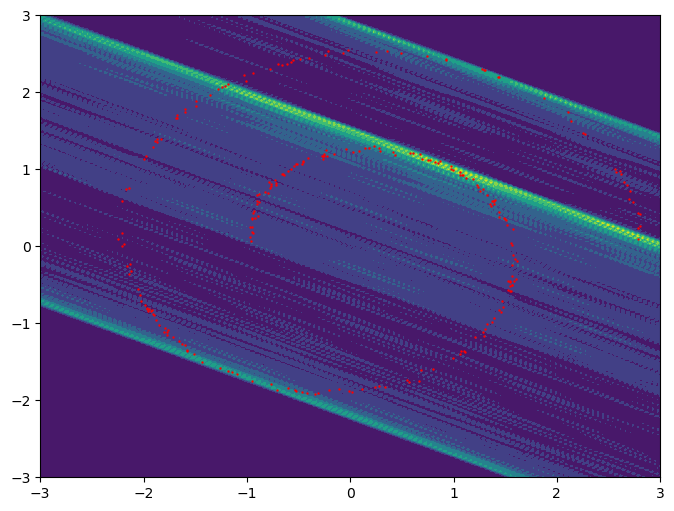

In [24]:


x = torch.tensor(np.meshgrid(np.linspace(-3, 3, 250), np.linspace(-3, 3, 250)), dtype=torch.float32).permute(1, 2, 0).reshape(-1, 2)
density,blah = mog_density_2d_marg(x, centers, vectors_to_precision(factornet(centers)),1)
density = density.reshape(250, 250).T
# Plot the MoG density
plt.figure(figsize=(8, 6))
plt.contourf(np.linspace(-3, 3, 250), np.linspace(-3, 3, 250), density.detach().numpy(), cmap='viridis')
plt.scatter(samples[:,2],samples[:,0],color = 'red',s =0.5)